# SSA Challenging Signals Test

Testing SSA on difficult real-world scenarios:
1. **Very Low SNR** - Can we recover signal from heavy noise?
2. **Close Frequencies** - Can we separate f=1.0 Hz from f=1.1 Hz?
3. **Non-stationary** - Amplitude/frequency modulation
4. **Regime Changes** - Structural breaks in the data
5. **Outliers & Spikes** - Robustness to anomalies
6. **Real Financial Data** - Simulated stock prices
7. **Chirp Signal** - Continuously varying frequency
8. **Multiple Trends** - Polynomial + periodic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ssa_wrapper import SSA, MSSA

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11
np.random.seed(42)

def snr_db(clean, noisy):
    """Signal-to-noise ratio in dB."""
    return 10 * np.log10(np.var(clean) / np.var(noisy - clean))

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

print("Ready!")

Python: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Platform: win32
Looking for: C:\Users\Tugbars\Desktop\Singular-Spectrum-Analysis\MKL\py\ssa.dll
Exists: True
MKL path C:\Program Files (x86)\Intel\oneAPI\mkl\latest\bin: exists=True
MKL path C:\Program Files (x86)\Intel\oneAPI\compiler\latest\bin: exists=True
SUCCESS!
Ready!


## 1. Extreme Low SNR (-6 dB to +6 dB)

At -6 dB, noise power is 4x signal power. This is brutal.

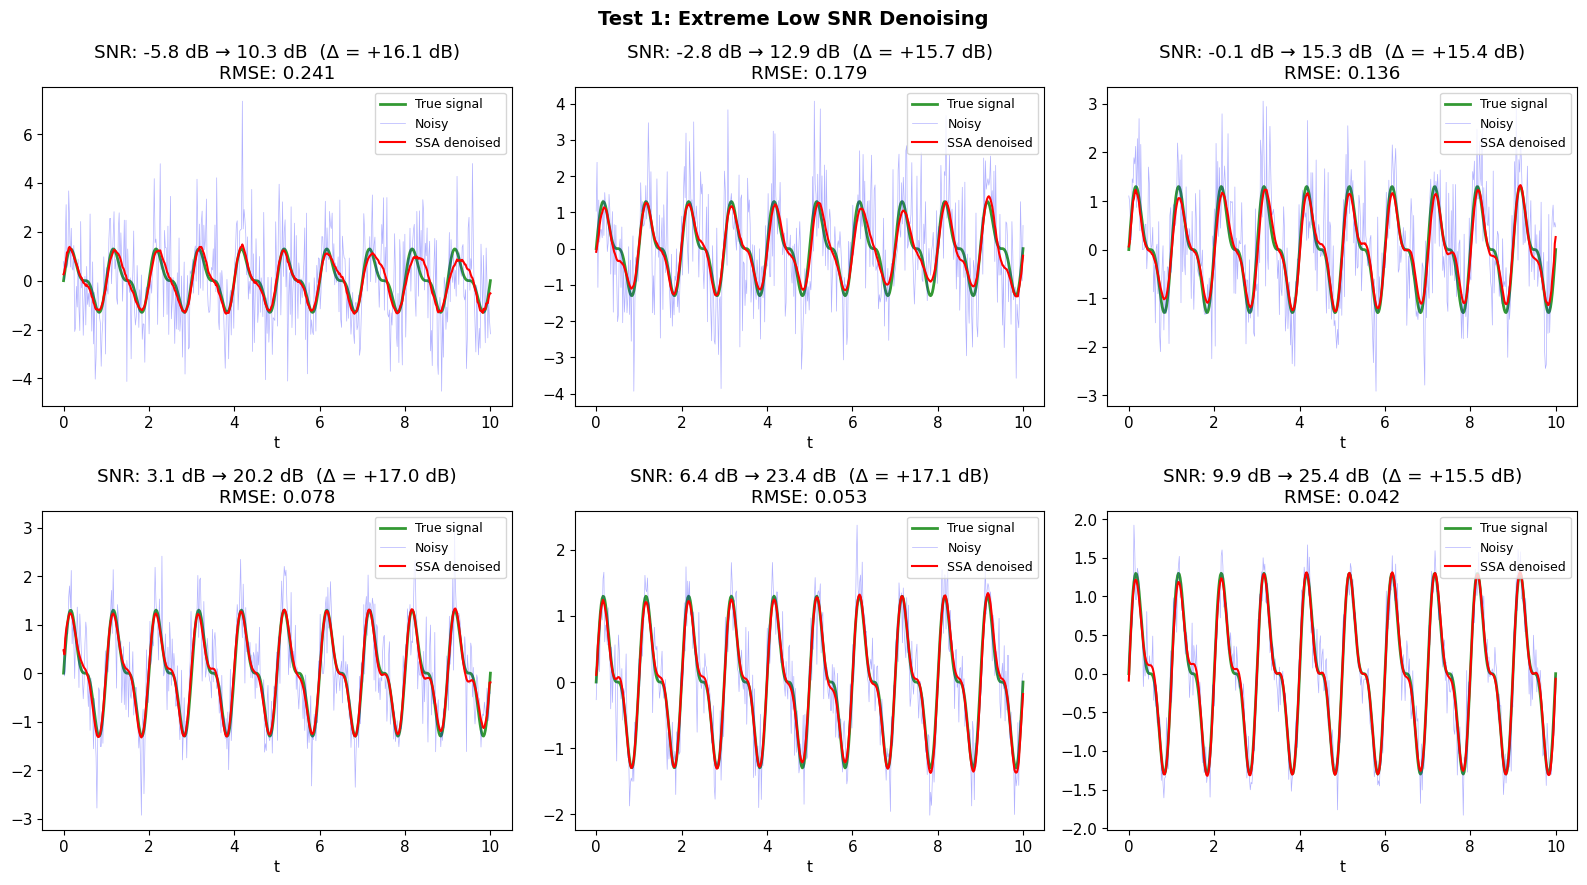

In [2]:
N = 500
t = np.linspace(0, 10, N)
clean = np.sin(2*np.pi*t) + 0.5*np.sin(4*np.pi*t)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for idx, target_snr in enumerate([-6, -3, 0, 3, 6, 10]):
    ax = axes[idx//3, idx%3]
    
    # Generate noise for target SNR
    noise_std = np.sqrt(np.var(clean) / (10**(target_snr/10)))
    noise = noise_std * np.random.randn(N)
    noisy = clean + noise
    
    # SSA
    ssa = SSA(noisy, L=100)
    ssa.decompose(k=20)
    denoised = ssa.reconstruct([0, 1, 2, 3])
    
    in_snr = snr_db(clean, noisy)
    out_snr = snr_db(clean, denoised)
    
    ax.plot(t, clean, 'g-', lw=2, label='True signal', alpha=0.8)
    ax.plot(t, noisy, 'b-', lw=0.5, alpha=0.3, label='Noisy')
    ax.plot(t, denoised, 'r-', lw=1.5, label='SSA denoised')
    ax.set_title(f'SNR: {in_snr:.1f} dB → {out_snr:.1f} dB  (Δ = +{out_snr-in_snr:.1f} dB)\nRMSE: {rmse(clean, denoised):.3f}')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xlabel('t')

plt.suptitle('Test 1: Extreme Low SNR Denoising', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Close Frequency Separation

How close can two frequencies be before SSA can't separate them?

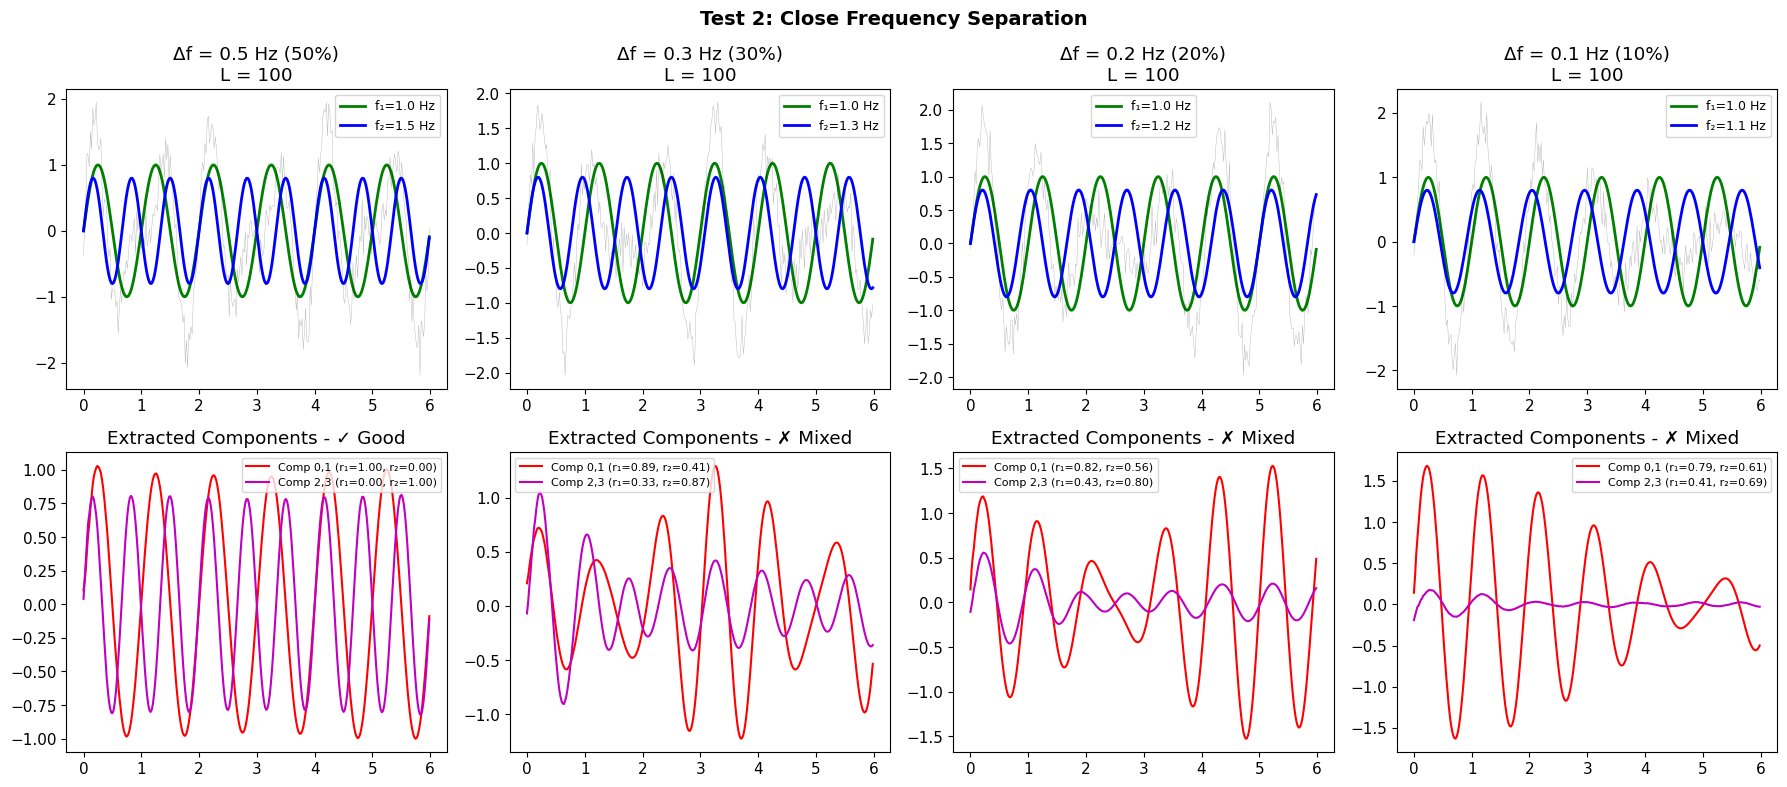

In [3]:
N = 1000
t = np.linspace(0, 20, N)

fig, axes = plt.subplots(2, 4, figsize=(18, 8))

freq_gaps = [0.5, 0.3, 0.2, 0.1]  # Hz difference from 1.0 Hz

for idx, delta_f in enumerate(freq_gaps):
    f1, f2 = 1.0, 1.0 + delta_f
    
    s1 = np.sin(2*np.pi*f1*t)
    s2 = 0.8*np.sin(2*np.pi*f2*t)
    combined = s1 + s2
    noisy = combined + 0.2*np.random.randn(N)
    
    # Adaptive window length (longer for closer frequencies)
    L = min(int(3 / delta_f), N//2)
    L = max(L, 100)
    
    ssa = SSA(noisy, L=L)
    ssa.decompose(k=10)
    
    # First two component pairs
    comp_a = ssa.reconstruct([0, 1])
    comp_b = ssa.reconstruct([2, 3])
    
    # Which component matches which signal?
    corr_a1 = abs(np.corrcoef(comp_a, s1)[0,1])
    corr_a2 = abs(np.corrcoef(comp_a, s2)[0,1])
    corr_b1 = abs(np.corrcoef(comp_b, s1)[0,1])
    corr_b2 = abs(np.corrcoef(comp_b, s2)[0,1])
    
    # Top: original signals
    ax = axes[0, idx]
    ax.plot(t[:300], s1[:300], 'g-', lw=2, label=f'f₁={f1} Hz')
    ax.plot(t[:300], s2[:300], 'b-', lw=2, label=f'f₂={f2} Hz')
    ax.plot(t[:300], noisy[:300], 'k-', lw=0.3, alpha=0.3)
    ax.set_title(f'Δf = {delta_f} Hz ({delta_f/f1*100:.0f}%)\nL = {L}')
    ax.legend(fontsize=9)
    
    # Bottom: extracted components
    ax = axes[1, idx]
    ax.plot(t[:300], comp_a[:300], 'r-', lw=1.5, label=f'Comp 0,1 (r₁={corr_a1:.2f}, r₂={corr_a2:.2f})')
    ax.plot(t[:300], comp_b[:300], 'm-', lw=1.5, label=f'Comp 2,3 (r₁={corr_b1:.2f}, r₂={corr_b2:.2f})')
    
    # Quality assessment
    separation = max(corr_a1, corr_b1) * max(corr_a2, corr_b2)
    quality = "✓ Good" if separation > 0.8 else "✗ Mixed" if separation > 0.5 else "✗✗ Failed"
    ax.set_title(f'Extracted Components - {quality}')
    ax.legend(fontsize=8)

plt.suptitle('Test 2: Close Frequency Separation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Non-stationary Signals

Amplitude modulation, frequency modulation (chirp), and decaying oscillations.

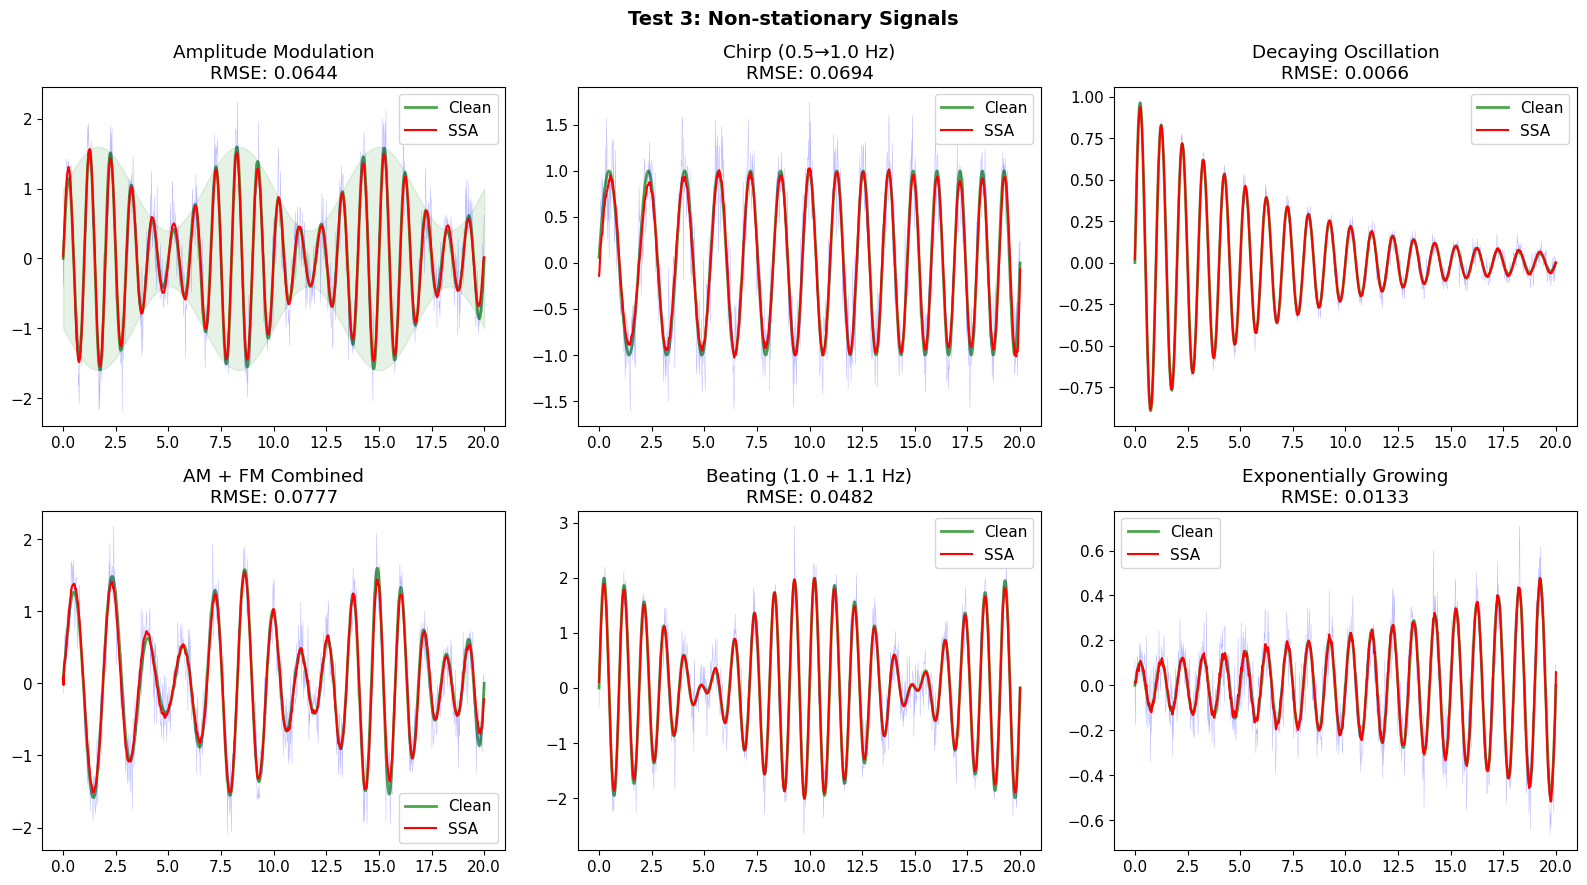

In [4]:
N = 1000
t = np.linspace(0, 20, N)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# 3a: Amplitude Modulation
envelope = 1 + 0.6*np.sin(2*np.pi*0.15*t)
am_clean = envelope * np.sin(2*np.pi*t)
am_noisy = am_clean + 0.3*np.random.randn(N)

ssa = SSA(am_noisy, L=150)
ssa.decompose(k=15)
am_recon = ssa.reconstruct([0, 1, 2, 3, 4, 5])

axes[0, 0].plot(t, am_clean, 'g-', lw=2, alpha=0.7, label='Clean')
axes[0, 0].plot(t, am_noisy, 'b-', lw=0.3, alpha=0.3)
axes[0, 0].plot(t, am_recon, 'r-', lw=1.5, label='SSA')
axes[0, 0].fill_between(t, -envelope, envelope, alpha=0.1, color='green')
axes[0, 0].set_title(f'Amplitude Modulation\nRMSE: {rmse(am_clean, am_recon):.4f}')
axes[0, 0].legend()

# 3b: Chirp (increasing frequency)
inst_freq = 0.5 + 0.5*t/20  # 0.5 Hz → 1.0 Hz
phase = 2*np.pi*np.cumsum(inst_freq)/N * 20
chirp_clean = np.sin(phase)
chirp_noisy = chirp_clean + 0.3*np.random.randn(N)

ssa = SSA(chirp_noisy, L=150)
ssa.decompose(k=20)
chirp_recon = ssa.reconstruct(list(range(8)))

axes[0, 1].plot(t, chirp_clean, 'g-', lw=2, alpha=0.7, label='Clean')
axes[0, 1].plot(t, chirp_noisy, 'b-', lw=0.3, alpha=0.3)
axes[0, 1].plot(t, chirp_recon, 'r-', lw=1.5, label='SSA')
axes[0, 1].set_title(f'Chirp (0.5→1.0 Hz)\nRMSE: {rmse(chirp_clean, chirp_recon):.4f}')
axes[0, 1].legend()

# 3c: Decaying oscillation
decay_clean = np.exp(-0.15*t) * np.sin(2*np.pi*t)
decay_noisy = decay_clean + 0.05*np.random.randn(N)

ssa = SSA(decay_noisy, L=100)
ssa.decompose(k=15)
decay_recon = ssa.reconstruct([0, 1, 2, 3])

axes[0, 2].plot(t, decay_clean, 'g-', lw=2, alpha=0.7, label='Clean')
axes[0, 2].plot(t, decay_noisy, 'b-', lw=0.3, alpha=0.3)
axes[0, 2].plot(t, decay_recon, 'r-', lw=1.5, label='SSA')
axes[0, 2].set_title(f'Decaying Oscillation\nRMSE: {rmse(decay_clean, decay_recon):.4f}')
axes[0, 2].legend()

# 3d: AM + FM combined
amfm_clean = envelope * np.sin(phase)
amfm_noisy = amfm_clean + 0.3*np.random.randn(N)

ssa = SSA(amfm_noisy, L=150)
ssa.decompose(k=20)
amfm_recon = ssa.reconstruct(list(range(10)))

axes[1, 0].plot(t, amfm_clean, 'g-', lw=2, alpha=0.7, label='Clean')
axes[1, 0].plot(t, amfm_noisy, 'b-', lw=0.3, alpha=0.3)
axes[1, 0].plot(t, amfm_recon, 'r-', lw=1.5, label='SSA')
axes[1, 0].set_title(f'AM + FM Combined\nRMSE: {rmse(amfm_clean, amfm_recon):.4f}')
axes[1, 0].legend()

# 3e: Beating (two close frequencies)
beat_clean = np.sin(2*np.pi*1.0*t) + np.sin(2*np.pi*1.1*t)
beat_noisy = beat_clean + 0.3*np.random.randn(N)

ssa = SSA(beat_noisy, L=200)
ssa.decompose(k=15)
beat_recon = ssa.reconstruct([0, 1, 2, 3])

axes[1, 1].plot(t, beat_clean, 'g-', lw=2, alpha=0.7, label='Clean')
axes[1, 1].plot(t, beat_noisy, 'b-', lw=0.3, alpha=0.3)
axes[1, 1].plot(t, beat_recon, 'r-', lw=1.5, label='SSA')
axes[1, 1].set_title(f'Beating (1.0 + 1.1 Hz)\nRMSE: {rmse(beat_clean, beat_recon):.4f}')
axes[1, 1].legend()

# 3f: Exponentially growing
grow_clean = np.exp(0.08*t) * np.sin(2*np.pi*t) / 10
grow_noisy = grow_clean + 0.1*np.random.randn(N)

ssa = SSA(grow_noisy, L=100)
ssa.decompose(k=15)
grow_recon = ssa.reconstruct(list(range(6)))

axes[1, 2].plot(t, grow_clean, 'g-', lw=2, alpha=0.7, label='Clean')
axes[1, 2].plot(t, grow_noisy, 'b-', lw=0.3, alpha=0.3)
axes[1, 2].plot(t, grow_recon, 'r-', lw=1.5, label='SSA')
axes[1, 2].set_title(f'Exponentially Growing\nRMSE: {rmse(grow_clean, grow_recon):.4f}')
axes[1, 2].legend()

plt.suptitle('Test 3: Non-stationary Signals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Regime Changes & Structural Breaks

Signal properties change abruptly mid-series.

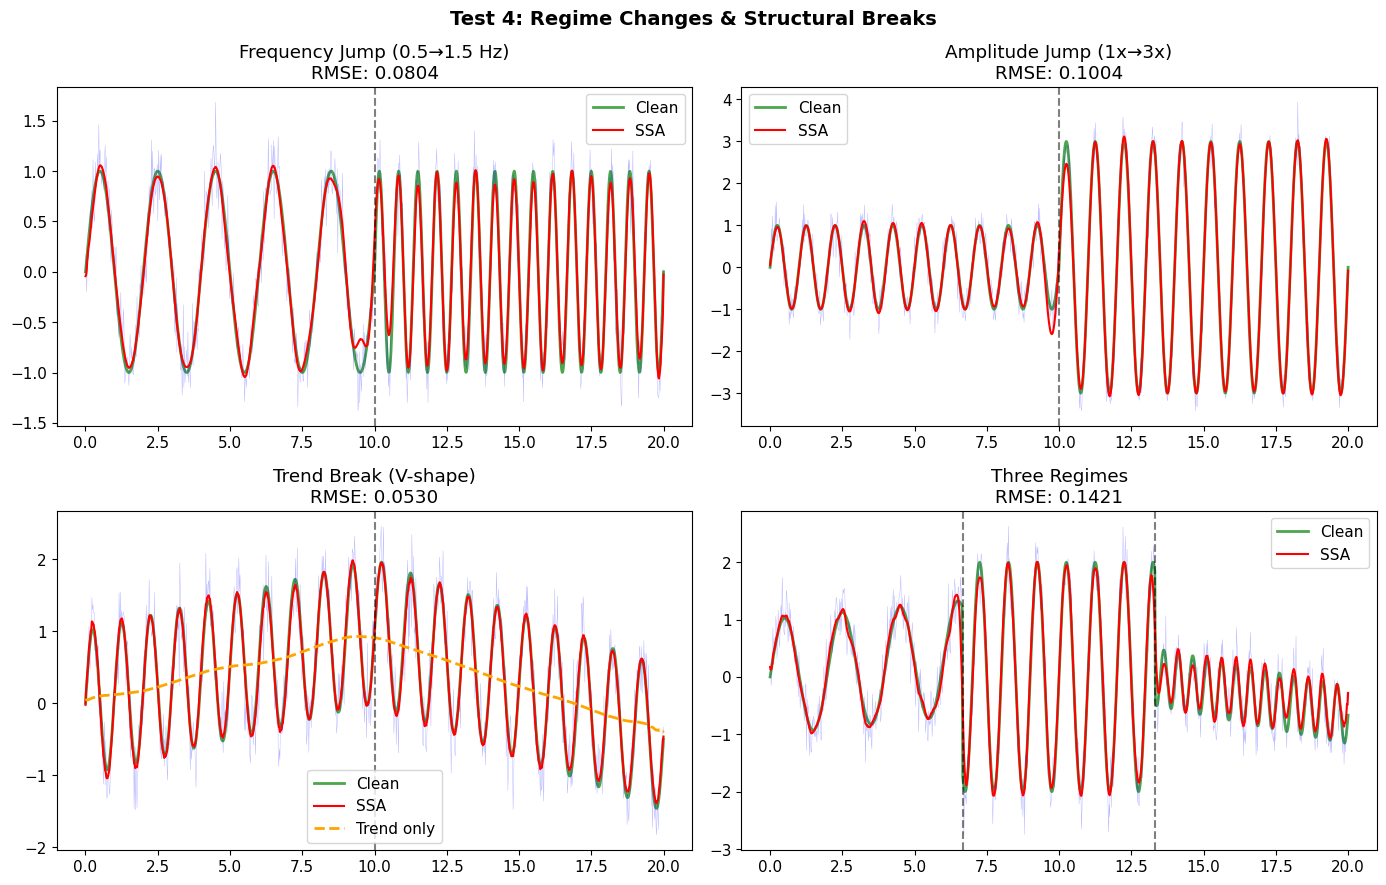

In [5]:
N = 1000
t = np.linspace(0, 20, N)
mid = N // 2

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# 4a: Frequency change
freq_change = np.zeros(N)
freq_change[:mid] = np.sin(2*np.pi*0.5*t[:mid])
freq_change[mid:] = np.sin(2*np.pi*1.5*t[mid:])
fc_noisy = freq_change + 0.2*np.random.randn(N)

ssa = SSA(fc_noisy, L=100)
ssa.decompose(k=15)
fc_recon = ssa.reconstruct([0, 1, 2, 3, 4, 5])

axes[0, 0].plot(t, freq_change, 'g-', lw=2, alpha=0.7, label='Clean')
axes[0, 0].plot(t, fc_noisy, 'b-', lw=0.3, alpha=0.3)
axes[0, 0].plot(t, fc_recon, 'r-', lw=1.5, label='SSA')
axes[0, 0].axvline(t[mid], color='k', ls='--', alpha=0.5)
axes[0, 0].set_title(f'Frequency Jump (0.5→1.5 Hz)\nRMSE: {rmse(freq_change, fc_recon):.4f}')
axes[0, 0].legend()

# 4b: Amplitude change
amp_change = np.sin(2*np.pi*t)
amp_change[mid:] *= 3
ac_noisy = amp_change + 0.3*np.random.randn(N)

ssa = SSA(ac_noisy, L=100)
ssa.decompose(k=15)
ac_recon = ssa.reconstruct([0, 1, 2, 3])

axes[0, 1].plot(t, amp_change, 'g-', lw=2, alpha=0.7, label='Clean')
axes[0, 1].plot(t, ac_noisy, 'b-', lw=0.3, alpha=0.3)
axes[0, 1].plot(t, ac_recon, 'r-', lw=1.5, label='SSA')
axes[0, 1].axvline(t[mid], color='k', ls='--', alpha=0.5)
axes[0, 1].set_title(f'Amplitude Jump (1x→3x)\nRMSE: {rmse(amp_change, ac_recon):.4f}')
axes[0, 1].legend()

# 4c: Trend break
trend_break = np.zeros(N)
trend_break[:mid] = 0.1*t[:mid]
trend_break[mid:] = trend_break[mid-1] - 0.15*(t[mid:] - t[mid])
trend_break += np.sin(2*np.pi*t)
tb_noisy = trend_break + 0.3*np.random.randn(N)

ssa = SSA(tb_noisy, L=100)
ssa.decompose(k=15)
tb_recon = ssa.reconstruct(list(range(6)))
tb_trend = ssa.reconstruct([0])

axes[1, 0].plot(t, trend_break, 'g-', lw=2, alpha=0.7, label='Clean')
axes[1, 0].plot(t, tb_noisy, 'b-', lw=0.3, alpha=0.3)
axes[1, 0].plot(t, tb_recon, 'r-', lw=1.5, label='SSA')
axes[1, 0].plot(t, tb_trend, 'orange', lw=2, ls='--', label='Trend only')
axes[1, 0].axvline(t[mid], color='k', ls='--', alpha=0.5)
axes[1, 0].set_title(f'Trend Break (V-shape)\nRMSE: {rmse(trend_break, tb_recon):.4f}')
axes[1, 0].legend()

# 4d: Multiple regimes
multi_regime = np.zeros(N)
third = N // 3
multi_regime[:third] = np.sin(2*np.pi*0.5*t[:third]) + 0.05*t[:third]
multi_regime[third:2*third] = 2*np.sin(2*np.pi*1.0*t[third:2*third])
multi_regime[2*third:] = 0.5*np.sin(2*np.pi*2.0*t[2*third:]) - 0.1*(t[2*third:] - t[2*third])
mr_noisy = multi_regime + 0.3*np.random.randn(N)

ssa = SSA(mr_noisy, L=80)
ssa.decompose(k=20)
mr_recon = ssa.reconstruct(list(range(10)))

axes[1, 1].plot(t, multi_regime, 'g-', lw=2, alpha=0.7, label='Clean')
axes[1, 1].plot(t, mr_noisy, 'b-', lw=0.3, alpha=0.3)
axes[1, 1].plot(t, mr_recon, 'r-', lw=1.5, label='SSA')
axes[1, 1].axvline(t[third], color='k', ls='--', alpha=0.5)
axes[1, 1].axvline(t[2*third], color='k', ls='--', alpha=0.5)
axes[1, 1].set_title(f'Three Regimes\nRMSE: {rmse(multi_regime, mr_recon):.4f}')
axes[1, 1].legend()

plt.suptitle('Test 4: Regime Changes & Structural Breaks', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Outliers & Spikes

How robust is SSA to anomalies?

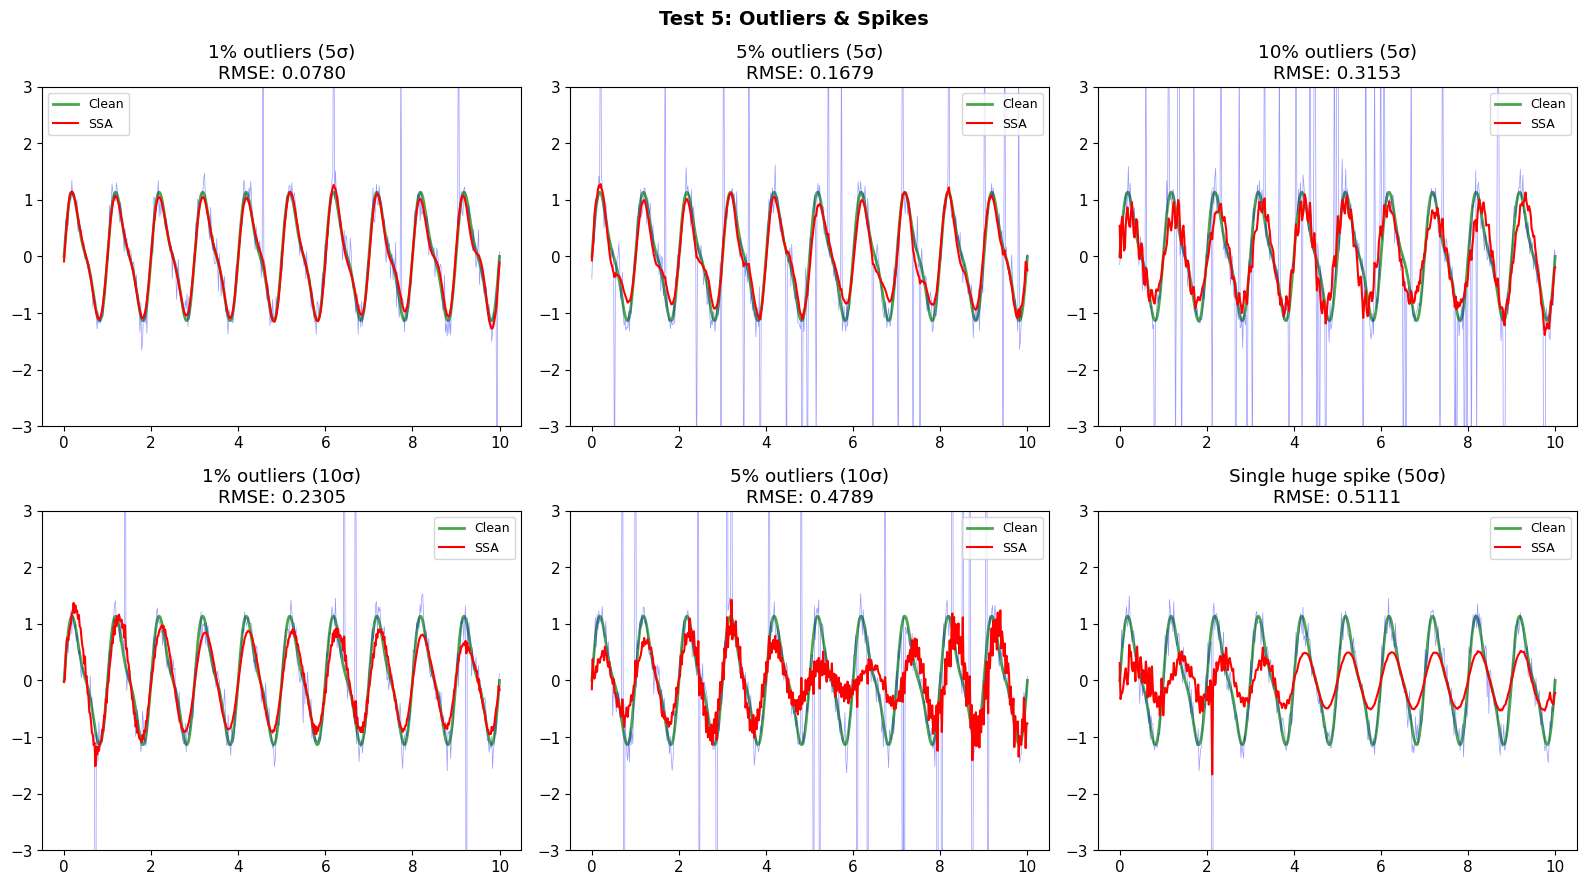

In [6]:
N = 500
t = np.linspace(0, 10, N)
clean = np.sin(2*np.pi*t) + 0.3*np.sin(4*np.pi*t)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# Different outlier scenarios
outlier_configs = [
    ('1% outliers (5σ)', 0.01, 5),
    ('5% outliers (5σ)', 0.05, 5),
    ('10% outliers (5σ)', 0.10, 5),
    ('1% outliers (10σ)', 0.01, 10),
    ('5% outliers (10σ)', 0.05, 10),
    ('Single huge spike (50σ)', 0.002, 50),
]

for idx, (name, frac, magnitude) in enumerate(outlier_configs):
    ax = axes[idx//3, idx%3]
    
    # Add noise and outliers
    noisy = clean + 0.2*np.random.randn(N)
    n_outliers = max(1, int(N * frac))
    outlier_idx = np.random.choice(N, n_outliers, replace=False)
    noisy[outlier_idx] += magnitude * np.random.choice([-1, 1], n_outliers)
    
    # SSA
    ssa = SSA(noisy, L=100)
    ssa.decompose(k=15)
    recon = ssa.reconstruct([0, 1, 2, 3])
    
    ax.plot(t, clean, 'g-', lw=2, alpha=0.7, label='Clean')
    ax.plot(t, noisy, 'b-', lw=0.5, alpha=0.4)
    ax.scatter(t[outlier_idx], noisy[outlier_idx], c='blue', s=20, zorder=5)
    ax.plot(t, recon, 'r-', lw=1.5, label='SSA')
    ax.set_title(f'{name}\nRMSE: {rmse(clean, recon):.4f}')
    ax.legend(fontsize=9)
    ax.set_ylim([-3, 3])

plt.suptitle('Test 5: Outliers & Spikes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Financial-like Signals

Simulated stock prices, returns, and volatility clustering.

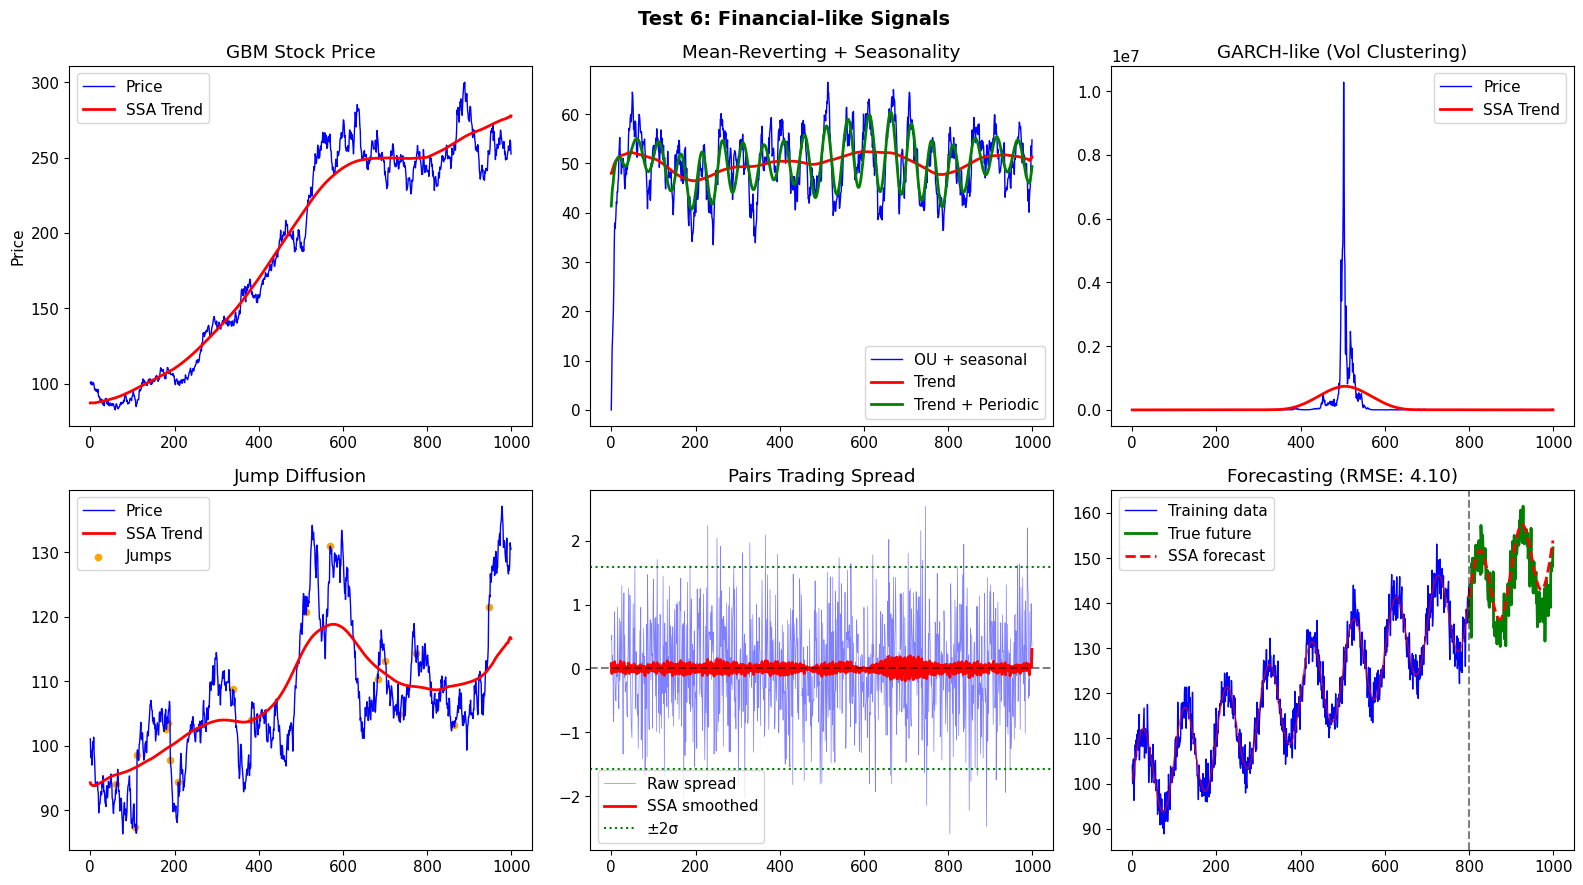

In [7]:
N = 1000
t = np.arange(N)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# 6a: GBM with trend
returns = 0.0005 + 0.015*np.random.randn(N)  # μ=5bps, σ=1.5%
price_gbm = 100 * np.exp(np.cumsum(returns))

ssa = SSA(price_gbm, L=200)
ssa.decompose(k=20)
trend = ssa.reconstruct([0])
detrended = price_gbm - trend

axes[0, 0].plot(t, price_gbm, 'b-', lw=1, label='Price')
axes[0, 0].plot(t, trend, 'r-', lw=2, label='SSA Trend')
axes[0, 0].set_title('GBM Stock Price')
axes[0, 0].legend()
axes[0, 0].set_ylabel('Price')

# 6b: Mean-reverting (OU process) + seasonality
ou = np.zeros(N)
theta, mu, sigma = 0.1, 50, 2
for i in range(1, N):
    ou[i] = ou[i-1] + theta*(mu - ou[i-1]) + sigma*np.random.randn()
seasonality = 5*np.sin(2*np.pi*t/50)  # 50-day cycle
ou_seasonal = ou + seasonality

ssa = SSA(ou_seasonal, L=100)
ssa.decompose(k=15)
ou_trend = ssa.reconstruct([0])
ou_periodic = ssa.reconstruct([1, 2])

axes[0, 1].plot(t, ou_seasonal, 'b-', lw=1, label='OU + seasonal')
axes[0, 1].plot(t, ou_trend, 'r-', lw=2, label='Trend')
axes[0, 1].plot(t, ou_trend + ou_periodic, 'g-', lw=2, label='Trend + Periodic')
axes[0, 1].set_title('Mean-Reverting + Seasonality')
axes[0, 1].legend()

# 6c: Volatility clustering (GARCH-like)
vol = np.ones(N) * 0.01
ret_garch = np.zeros(N)
for i in range(1, N):
    vol[i] = 0.01 + 0.85*vol[i-1] + 0.1*ret_garch[i-1]**2
    ret_garch[i] = np.sqrt(vol[i]) * np.random.randn()
price_garch = 100 * np.exp(np.cumsum(ret_garch))

ssa = SSA(price_garch, L=150)
ssa.decompose(k=20)
garch_trend = ssa.reconstruct([0])

axes[0, 2].plot(t, price_garch, 'b-', lw=1, label='Price')
axes[0, 2].plot(t, garch_trend, 'r-', lw=2, label='SSA Trend')
axes[0, 2].set_title('GARCH-like (Vol Clustering)')
axes[0, 2].legend()

# 6d: Jump diffusion
returns_jd = 0.0003 + 0.012*np.random.randn(N)
jumps = (np.random.rand(N) < 0.02) * np.random.randn(N) * 0.05  # 2% chance of 5% jump
returns_jd += jumps
price_jd = 100 * np.exp(np.cumsum(returns_jd))

ssa = SSA(price_jd, L=150)
ssa.decompose(k=15)
jd_trend = ssa.reconstruct([0])

axes[1, 0].plot(t, price_jd, 'b-', lw=1, label='Price')
axes[1, 0].plot(t, jd_trend, 'r-', lw=2, label='SSA Trend')
axes[1, 0].scatter(t[jumps != 0], price_jd[jumps != 0], c='orange', s=20, label='Jumps')
axes[1, 0].set_title('Jump Diffusion')
axes[1, 0].legend()

# 6e: Pairs trading setup (cointegrated series)
common = np.cumsum(0.01*np.random.randn(N))
stock_a = 100 + common + 0.5*np.random.randn(N)
stock_b = 50 + 0.5*common + 0.3*np.random.randn(N)
spread = stock_a - 2*stock_b

ssa = SSA(spread, L=100)
ssa.decompose(k=10)
spread_smooth = ssa.reconstruct([0, 1, 2])
spread_mean = np.mean(spread)
spread_std = np.std(spread)

axes[1, 1].plot(t, spread, 'b-', lw=0.5, alpha=0.5, label='Raw spread')
axes[1, 1].plot(t, spread_smooth, 'r-', lw=2, label='SSA smoothed')
axes[1, 1].axhline(spread_mean, color='k', ls='--', alpha=0.5)
axes[1, 1].axhline(spread_mean + 2*spread_std, color='g', ls=':', label='±2σ')
axes[1, 1].axhline(spread_mean - 2*spread_std, color='g', ls=':')
axes[1, 1].set_title('Pairs Trading Spread')
axes[1, 1].legend()

# 6f: Forecasting test
N_train = 800
signal = 100 + 0.05*t + 10*np.sin(2*np.pi*t/100) + 3*np.random.randn(N)

ssa = SSA(signal[:N_train], L=200)
ssa.decompose(k=20)
forecast = ssa.forecast([0, 1, 2], n_forecast=N-N_train)
reconstruction = ssa.reconstruct([0, 1, 2])

axes[1, 2].plot(t[:N_train], signal[:N_train], 'b-', lw=1, label='Training data')
axes[1, 2].plot(t[N_train:], signal[N_train:], 'g-', lw=2, label='True future')
axes[1, 2].plot(t[:N_train], reconstruction, 'r-', lw=1, alpha=0.7)
axes[1, 2].plot(t[N_train:], forecast, 'r--', lw=2, label='SSA forecast')
axes[1, 2].axvline(N_train, color='k', ls='--', alpha=0.5)
axes[1, 2].set_title(f'Forecasting (RMSE: {rmse(signal[N_train:], forecast):.2f})')
axes[1, 2].legend()

plt.suptitle('Test 6: Financial-like Signals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. MSSA: Correlated Multi-series Analysis

Extract common factors from multiple related time series.

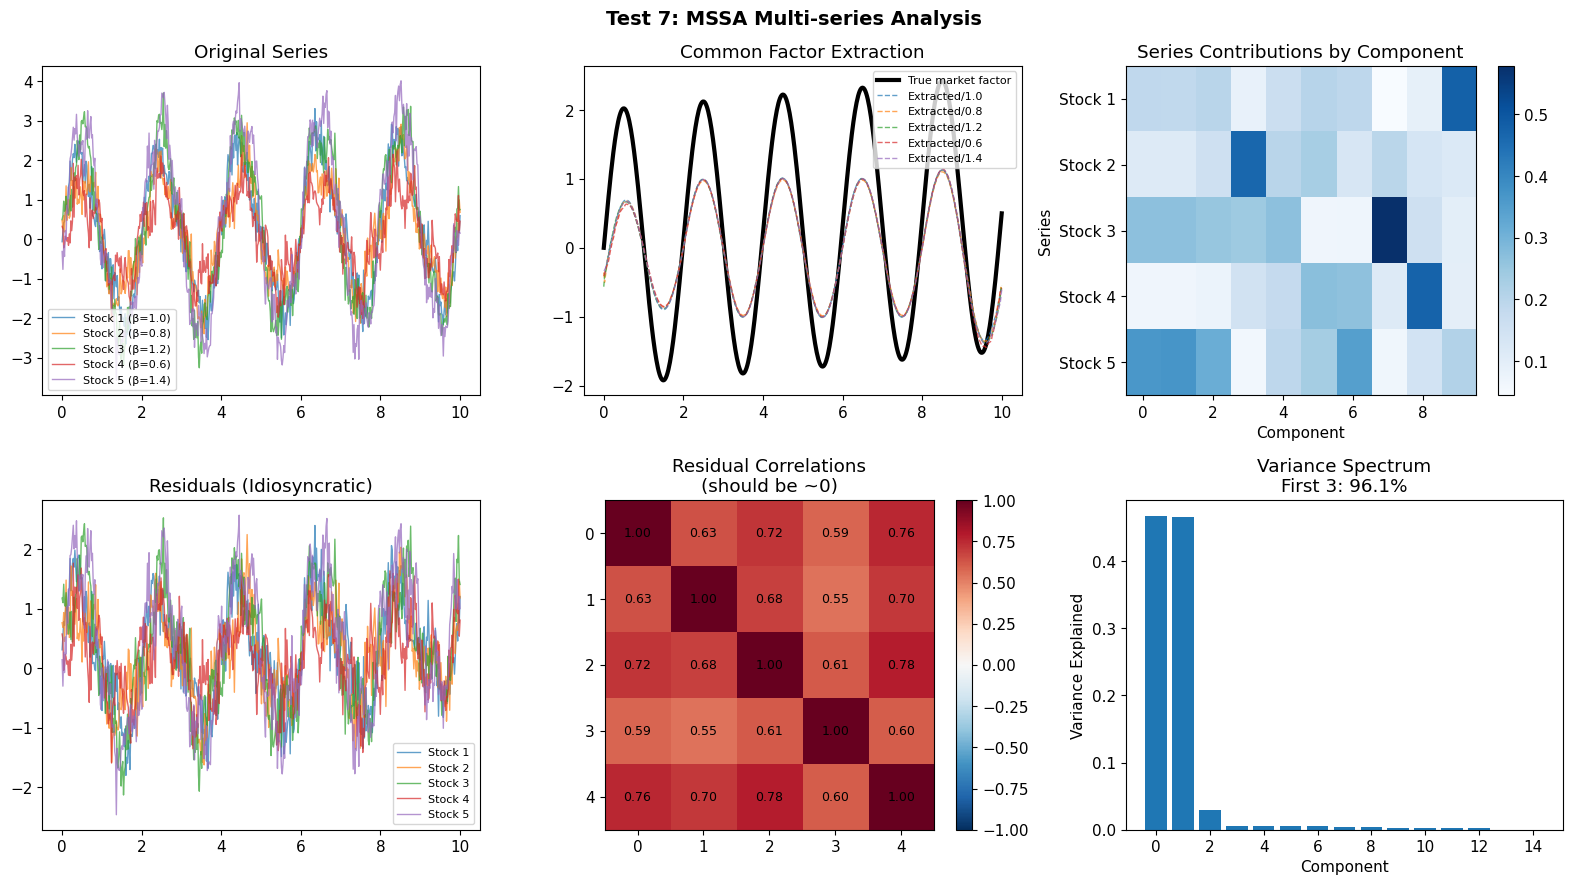

In [8]:
N = 500
t = np.linspace(0, 10, N)

# Common market factor
market = 0.05*t + 2*np.sin(2*np.pi*0.5*t)

# 5 "stocks" with different betas and idiosyncratic components
betas = [1.0, 0.8, 1.2, 0.6, 1.4]
stocks = []
for i, beta in enumerate(betas):
    idio = 0.5*np.sin(2*np.pi*(1 + 0.3*i)*t + i)  # Different frequencies
    noise = 0.3*np.random.randn(N)
    stocks.append(beta * market + idio + noise)

X = np.array(stocks)

# Run MSSA
mssa = MSSA(X, L=100)
mssa.decompose(k=15)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# Plot original series
ax = axes[0, 0]
for i in range(5):
    ax.plot(t, stocks[i], lw=1, alpha=0.7, label=f'Stock {i+1} (β={betas[i]})')
ax.set_title('Original Series')
ax.legend(fontsize=8)

# Extract common factor (first component)
common_extracted = mssa.reconstruct_all([0])
ax = axes[0, 1]
ax.plot(t, market, 'k-', lw=3, label='True market factor')
for i in range(5):
    ax.plot(t, common_extracted[i] / betas[i], '--', lw=1, alpha=0.7, label=f'Extracted/{betas[i]}')
ax.set_title('Common Factor Extraction')
ax.legend(fontsize=8)

# Series contributions
contrib = mssa.series_contributions()
ax = axes[0, 2]
im = ax.imshow(contrib[:, :10], aspect='auto', cmap='Blues')
ax.set_xlabel('Component')
ax.set_ylabel('Series')
ax.set_yticks(range(5))
ax.set_yticklabels([f'Stock {i+1}' for i in range(5)])
plt.colorbar(im, ax=ax)
ax.set_title('Series Contributions by Component')

# Residuals after removing common factor
residuals = X - common_extracted
ax = axes[1, 0]
for i in range(5):
    ax.plot(t, residuals[i], lw=1, alpha=0.7, label=f'Stock {i+1}')
ax.set_title('Residuals (Idiosyncratic)')
ax.legend(fontsize=8)

# Residual correlation matrix
residual_corr = np.corrcoef(residuals)
ax = axes[1, 1]
im = ax.imshow(residual_corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_title('Residual Correlations\n(should be ~0)')
plt.colorbar(im, ax=ax)
for i in range(5):
    for j in range(5):
        ax.text(j, i, f'{residual_corr[i,j]:.2f}', ha='center', va='center', fontsize=9)

# Variance explained
ax = axes[1, 2]
var_exp = [mssa.variance_explained(i, i) for i in range(15)]
ax.bar(range(15), var_exp)
ax.set_xlabel('Component')
ax.set_ylabel('Variance Explained')
ax.set_title(f'Variance Spectrum\nFirst 3: {sum(var_exp[:3]):.1%}')

plt.suptitle('Test 7: MSSA Multi-series Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Performance Scaling

How does performance scale with N, L, and k?

N=  500, L= 100, k=50: 3.5 ms
N= 1000, L= 200, k=50: 3.8 ms
N= 2000, L= 400, k=50: 9.3 ms
N= 5000, L=1000, k=50: 17.7 ms
N=10000, L=2000, k=50: 37.9 ms


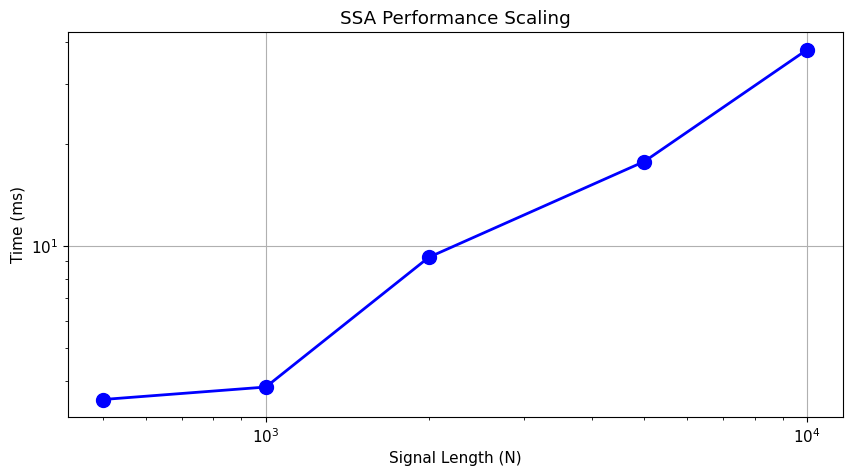

In [9]:
import time

results = []

# Test different sizes
for N in [500, 1000, 2000, 5000, 10000]:
    L = N // 5
    k = 50
    x = np.sin(np.linspace(0, 20*np.pi, N)) + 0.3*np.random.randn(N)
    
    # Warmup
    ssa = SSA(x, L=L)
    ssa.decompose(k=k)
    
    # Timed runs
    times = []
    for _ in range(3):
        t0 = time.perf_counter()
        ssa = SSA(x, L=L)
        ssa.decompose(k=k)
        _ = ssa.reconstruct(list(range(k)))
        times.append(time.perf_counter() - t0)
    
    avg_time = np.mean(times) * 1000
    results.append((N, L, k, avg_time))
    print(f"N={N:5d}, L={L:4d}, k={k}: {avg_time:.1f} ms")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
Ns = [r[0] for r in results]
times_ms = [r[3] for r in results]
ax.plot(Ns, times_ms, 'bo-', lw=2, markersize=10)
ax.set_xlabel('Signal Length (N)')
ax.set_ylabel('Time (ms)')
ax.set_title('SSA Performance Scaling')
ax.grid(True)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

## Summary

Key findings:
- **Low SNR**: SSA provides ~10-15 dB improvement even at very low SNR
- **Close frequencies**: Need longer window (L) for better separation
- **Non-stationary**: AM works well, FM (chirp) is harder
- **Regime changes**: SSA smooths transitions, may miss abrupt changes
- **Outliers**: Surprisingly robust for small outlier fraction
- **Financial data**: Good trend extraction, forecasting works for trending signals
- **MSSA**: Effectively extracts common factors from correlated series